In [2]:
import urllib.request
import zipfile
import os
import mindspore

# 下载 CIFAR-10 数据集
url = "https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/datasets/cifar10.zip"
filename = "cifar10.zip"
urllib.request.urlretrieve(url, filename)

# 解压缩 CIFAR-10 数据集
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('./data')

# 显示解压缩后的目录结构
for root, dirs, files in os.walk('./data/cifar10'):
    level = root.replace('./data/cifar10', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print('{}{}'.format(subindent, f))


cifar10/
    test/
        test_batch.bin
    train/
        batches.meta.txt
        data_batch_1.bin
        data_batch_2.bin
        data_batch_3.bin
        data_batch_4.bin
        data_batch_5.bin


[WARNING] ME(11720:13464,MainProcess):2023-06-03-15:10:59.394.757 [mindspore\dataset\core\validator_helpers.py:806] 'RandomCrop' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCrop' from mindspore.dataset.vision instead.
[WARNING] ME(11720:13464,MainProcess):2023-06-03-15:10:59.394.757 [mindspore\dataset\core\validator_helpers.py:806] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.
[WARNING] ME(11720:13464,MainProcess):2023-06-03-15:10:59.394.757 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(11720:13464,MainProcess):2023-06-03-15:10:59.398.723 [mindspore\dataset\cor

The dataset size is: 1562
The batch tensor is: (32, 3, 224, 224)


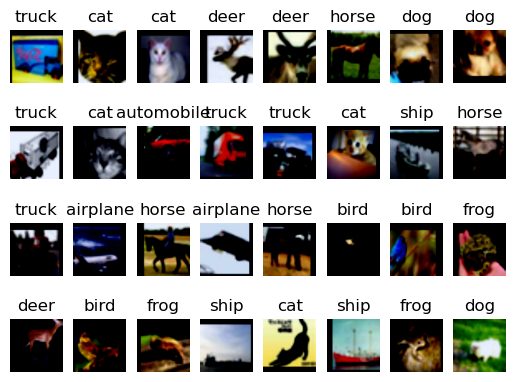

In [15]:
import mindspore.nn as nn
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
from mindspore import context
import numpy as np
import matplotlib.pyplot as plt
 
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
 
def create_dataset(data_home, repeat_num=1, batch_size=32, do_train=True, device_target="GPU"):
    """
    create data for next use such as training or inferring
    """
 
    cifar_ds = ds.Cifar10Dataset(data_home,num_parallel_workers=8, shuffle=True)
 
    c_trans = []
    if do_train:
        c_trans += [
            C.RandomCrop((32, 32), (4, 4, 4, 4)),
            C.RandomHorizontalFlip(prob=0.5)
        ]
 
    c_trans += [
        C.Resize((224, 224)),
        C.Rescale(1.0 / 255.0, 0.0),
        C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        C.HWC2CHW()
    ]
 
    type_cast_op = C2.TypeCast(mstype.int32)
 
    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    cifar_ds = cifar_ds.map(operations=c_trans, input_columns="image", num_parallel_workers=8)
 
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_num)
 
    return cifar_ds
 
 
ds_train_path = "./datasets/cifar10/train/"
dataset_show = create_dataset(ds_train_path)
with open(ds_train_path+"batches.meta.txt","r",encoding="utf-8") as f:
    all_name = [name.replace("\n","") for name in f.readlines()]
 
iterator_show= dataset_show.create_dict_iterator()
dict_data = next(iterator_show)
images = dict_data["image"].asnumpy()
labels = dict_data["label"].asnumpy()
count = 1
%matplotlib inline
for i in images:
    plt.subplot(4, 8, count)
    # Images[0].shape is (3,224,224).We need transpose as (224,224,3) for using in plt.show().
    picture_show = np.transpose(i,(1,2,0))
    picture_show = picture_show/np.amax(picture_show)
    picture_show = np.clip(picture_show, 0, 1)
    plt.title(all_name[labels[count-1]])
    picture_show = np.array(picture_show,np.float32)
    plt.imshow(picture_show)
    count += 1
    plt.axis("off")
 
print("The dataset size is:", dataset_show.get_dataset_size())
print("The batch tensor is:",images.shape)
plt.show()

In [16]:
import urllib.request

url = "https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/source-codes/resnet.py"
filename = "resnet.py"

urllib.request.urlretrieve(url, filename)


('resnet.py', <http.client.HTTPMessage at 0x249ca236dc0>)

In [17]:
from resnet import resnet50
 
net = resnet50(batch_size=32, num_classes=10)

In [18]:
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits
 
ls = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
opt = nn.Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.01, 0.9)

In [19]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import load_checkpoint, load_param_into_net
import os
from mindspore import Model
 
 
model = Model(net, loss_fn=ls, optimizer=opt, metrics={'acc'})
# As for train, users could use model.train
 
epoch_size = 10
ds_train_path = "./datasets/cifar10/train/"
model_path = "./models/ckpt/mindspore_vision_application/"
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))
 
dataset = create_dataset(ds_train_path )
batch_num = dataset.get_dataset_size()
config_ck = CheckpointConfig(save_checkpoint_steps=batch_num, keep_checkpoint_max=35)
ckpoint_cb = ModelCheckpoint(prefix="train_resnet_cifar10", directory=model_path, config=config_ck)
loss_cb = LossMonitor(142)
model.train(epoch_size, dataset, callbacks=[ckpoint_cb, loss_cb])

[WARNING] ME(11720:13464,MainProcess):2023-06-03-15:12:37.652.774 [mindspore\dataset\core\validator_helpers.py:806] 'RandomCrop' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCrop' from mindspore.dataset.vision instead.
[WARNING] ME(11720:13464,MainProcess):2023-06-03-15:12:37.652.774 [mindspore\dataset\core\validator_helpers.py:806] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.
[WARNING] ME(11720:13464,MainProcess):2023-06-03-15:12:37.656.757 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(11720:13464,MainProcess):2023-06-03-15:12:37.656.757 [mindspore\dataset\cor

KeyboardInterrupt: 